# Introduction


[Crossy Road](https://www.crossyroad.com/) is an arcade video game built around the age-old joke "Why did the chicken cross the road?" In the game, the chicken (controlled by the player) has to cross the road without getting hit by vehicles.

We want to develop a reinforcement learning (RL) game agent capable of playing Crossy Road. The game’s endless and random nature makes it a great candidate for RL.

The agent will learn to maximize its score by getting the chicken to cross the road and avoid obstacles in its path, with the ultimate goal of crossing the road as many times as possible without collisions. Once the agent is capable of successfully getting the chicken to cross the road and reach the goal position, another goal could be to minimize the time it takes for the chicken to cross the road.


# Configuration


There are several things we need to configure before we can begin.


## Importing Libraries


We'll start by importing the necessary [Python](https://www.python.org/) libraries.


In [32]:
import copy
import math
import random
from collections import deque, namedtuple
from datetime import datetime
from itertools import count
from pathlib import Path

import cv2
import gymnasium as gym
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from gymnasium.wrappers import TransformObservation, TransformReward
from matplotlib.ticker import MaxNLocator
from torchvision.transforms import v2
from tqdm import trange

try:
    from google.colab.patches import cv2_imshow
except ImportError:
    # code taken from: https://github.com/googlecolab/colabtools/blob/main/google/colab/patches/__init__.py
    import PIL.Image
    from IPython import display

    def cv2_imshow(a, convert=True):
        """A replacement for cv2.imshow() for use in Jupyter notebooks.

        Args:
            a: np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. For
            example, a shape of (N, M, 3) is an NxM BGR color image, and a shape of
            (N, M, 4) is an NxM BGRA color image.
            convert: boolean.
        """
        a = a.clip(0, 255).astype("uint8")
        # cv2 stores colors as BGR; convert to RGB
        if convert:
            if a.ndim == 3:
                if a.shape[2] == 4:
                    a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
                else:
                    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
        display.display(PIL.Image.fromarray(a))

## Controlling Randomness


Next, we'll make our results more reproducible (deterministic) by controlling sources of randomness, following the [suggestions outlined in the PyTorch docs](https://pytorch.org/docs/stable/notes/randomness.html).


In [33]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## Setting Device


We'll also select a [device](https://pytorch.org/docs/stable/tensor_attributes.html#torch.device) to store our tensors on.


In [34]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Crossy Road Environment


Our first step is to implement a Crossy Road environment, which will encapsulate our representation of the reinforcement learning problem that the game poses.

For this, we will utilize the [Gymnasium](https://gymnasium.farama.org/) library (a fork of the [OpenAI Gym](https://openai.com/research/openai-gym-beta) library), which provides a standard API for RL and various reference environments.

Specifically, we will use the [Freeway](https://gymnasium.farama.org/environments/atari/freeway/) environment, which models an [Atari](https://atari.com/) game that closely resembles Crossy Road. This gives us a Pythonic interface to work with, which we can later use to develop RL models and create an agent that can play Crossy Road successfully.


## Initializing the Environment


We will start off by initializing the environment using Gymnasium.

We pass in the following arguments (documented [here](https://gymnasium.farama.org/environments/atari/)) to specify the environment:

**Environment Flavor:**

The environment `id`, `mode`, and `difficulty` combine to specify the specific flavor of the environment:

- `id="ALE/Freeway-v5"`: simulates the Atari game Freeway via the [Arcade Learning Environment (ALE)](https://github.com/Farama-Foundation/Arcade-Learning-Environment) through the [Stella](https://stella-emu.github.io/) emulator
- `mode=0`: selects [Game 1 (Lake Shore Drive, Chicago, 3 A.M.)](https://atariage.com/manual_html_page.php?SoftwareLabelID=192) as the map to use
- `difficulty=0`: selects the default difficulty setting

**Stochasticity:**

As stated in the documentation:

> As the Atari games are entirely deterministic, agents can achieve state-of-the-art performance by simply memorizing an optimal sequence of actions while completely ignoring observations from the environment.

To combat this, we use `frameskip` and `repeat_action_probability`:

- `frameskip=4`: enables frame skipping (sets the number of frames to skip on each skip to $4$)
- `repeat_action_probability=0.25`: enables sticky actions (sets the probability of repeating the previous action instead of executing the current action to $25\%$)

**Simulation:**

The parameters `full_action_space` and `render_mode` are used to specify how the environment is simulated:

- `full_action_space=False`: limits the action space to the $3$ legal actions we will actually use instead of all $18$ possible actions that can be performed on an Atari 2600 console
- `render_mode="rgb_array"`: specifies that the game should be rendered as an RGB frame


In [35]:
env = gym.make(
    id="ALE/Freeway-v5",
    mode=0,
    difficulty=0,
    obs_type="rgb",
    frameskip=4,
    repeat_action_probability=0.25,
    full_action_space=False,
    render_mode="rgb_array",
)

We will also modify the metadata to set `render_fps` to $30$, meaning the game will run at $30$ frames per second.


In [36]:
env.metadata["render_fps"] = 30

Now, we are ready to learn a little more about how out environment is implemented.


## Observations


Let's start with the observation space.


In [37]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

This observation space represents the RGB image that is displayed to a human player.


## Actions


Next, let's move on to the action space.


In [38]:
env.action_space

Discrete(3)

This action space represents the actions that the chicken can take in each step:


In [39]:
action_meaning = {
    0: "NOOP",
    1: "UP",
    2: "DOWN",
}
print(action_meaning)

{0: 'NOOP', 1: 'UP', 2: 'DOWN'}


## Rewards


Finally, let's move on to the reward range.


In [40]:
env.reward_range

(-inf, inf)

We can see that the reward range is $(-\infty, \infty)$. However, this is not very informative.

As the documentation tells us:

> You receive a point for every chicken that makes it to the top of the screen after crossing all the lanes of traffic.


### Reward Modification

As the reward is currently, it is not suitable for training.

There are two actions that can be taken, moving the chicken up or down. However, the current reward function does not give a positive or negative reward for each individual action. There is only point for when you reach the end. We cannot train using RL techniques if the model can not associate and calculate rewards with each action.

As such, we will modify the reward such that there is a slight negative penality at each step. This will encourage the model to be quicker and move towards the goal since if it moves backwards or stays in the same spot the reward becomes more negative.


In [41]:
env = TransformReward(env, lambda r: r - 0.05)

# Agent-Environment Interaction


Our next step is to create a mechanism by which an agent can interact with the environment.


First, let's create a `log_step()` function that logs information about a certain time step.


In [42]:
def log_step(step, action, observation, reward, terminated, truncated, info):
    print(f"\n***** Step {step} *****\n")
    if action is not None:
        print(f"Action: {action} ({action_meaning[action]})")
    if observation is not None:
        print("Observation:", observation)
    if reward is not None:
        print("Reward:", reward)
    if terminated is not None:
        print("Terminated:", terminated)
    if truncated is not None:
        print("Truncated:", truncated)
    if info is not None:
        print("Info:", info)

Now, let's create a `simulate()` function that takes in an environment, agent, and number of episodes.

It simulates running `num_episodes` episodes in the environment `env`, where the player's actions are defined by the behavior of `agent`.


In [43]:
def simulate(
    env: gym.Env, transform: any, agent: any, num_episodes: int, step_show_freq: int
):
    for episode in range(num_episodes):
        print(f"########## Episode {episode} ##########")
        step = 0
        action = None
        observation, info = env.reset()
        reward, terminated, truncated = 0.0, False, False
        if step % step_show_freq == 0:
            log_step(step, action, None, reward, terminated, truncated, info)
            view = env.render()
            cv2_imshow(view, convert=False)
        while not (terminated or truncated):
            step += 1
            action = agent.sample_action(transform(observation))
            observation, reward, terminated, truncated, info = env.step(action.item())
            if step % step_show_freq == 0:
                log_step(step, action.item(), None, reward, terminated, truncated, info)
                view = env.render()
                cv2_imshow(view, convert=False)

# Random Agent


To test our environment, let's create a `RandomAgent`.


## Sampling an Action at Random


The agent will simply move the chicken randomly by sampling actions at random from the action space of the environment.


In [44]:
class RandomAgent:
    def __init__(self, env):
        self.env = env

    def sample_action(self, _observation):
        action = self.env.action_space.sample()
        return torch.tensor(data=action, dtype=torch.int32, device=device)

## Simulation


Now, let's run a simulation.

To limit the amount of output we need to scroll through, we will only show every $100$ steps.


########## Episode 0 ##########

***** Step 0 *****

Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 0, 'frame_number': 0}


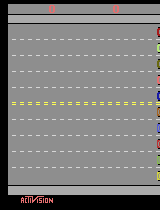


***** Step 100 *****

Action: 2 (DOWN)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 400, 'frame_number': 400}


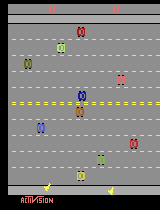


***** Step 200 *****

Action: 2 (DOWN)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 800, 'frame_number': 800}


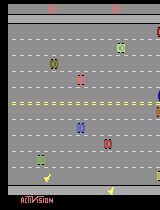


***** Step 300 *****

Action: 1 (UP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 1200, 'frame_number': 1200}


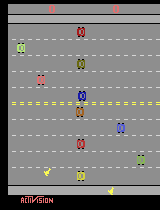


***** Step 400 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 1600, 'frame_number': 1600}


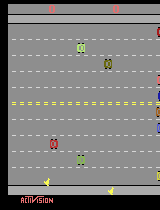


***** Step 500 *****

Action: 1 (UP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 2000, 'frame_number': 2000}


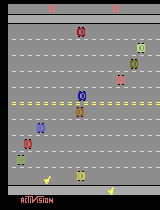


***** Step 600 *****

Action: 2 (DOWN)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 2400, 'frame_number': 2400}


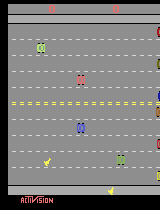


***** Step 700 *****

Action: 1 (UP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 2800, 'frame_number': 2800}


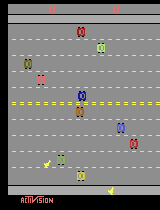


***** Step 800 *****

Action: 2 (DOWN)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 3200, 'frame_number': 3200}


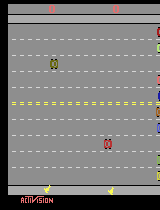


***** Step 900 *****

Action: 1 (UP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 3600, 'frame_number': 3600}


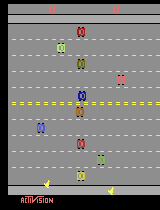


***** Step 1000 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 4000, 'frame_number': 4000}


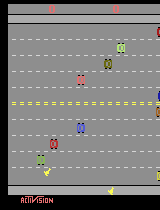


***** Step 1100 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 4400, 'frame_number': 4400}


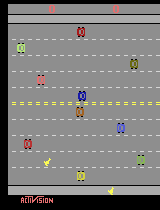


***** Step 1200 *****

Action: 1 (UP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 4800, 'frame_number': 4800}


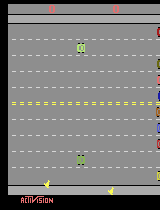


***** Step 1300 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 5200, 'frame_number': 5200}


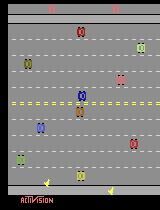


***** Step 1400 *****

Action: 1 (UP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 5600, 'frame_number': 5600}


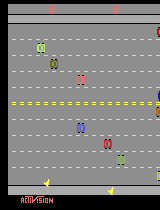


***** Step 1500 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 6000, 'frame_number': 6000}


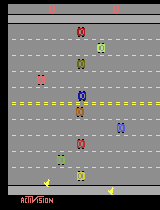


***** Step 1600 *****

Action: 1 (UP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 6400, 'frame_number': 6400}


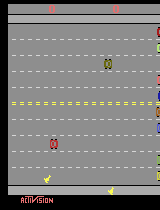


***** Step 1700 *****

Action: 1 (UP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 6800, 'frame_number': 6800}


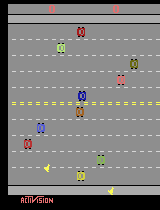


***** Step 1800 *****

Action: 2 (DOWN)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 7200, 'frame_number': 7200}


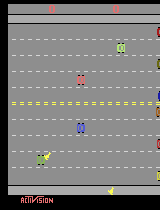


***** Step 1900 *****

Action: 1 (UP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 7600, 'frame_number': 7600}


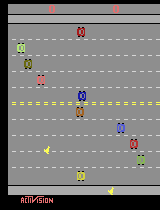


***** Step 2000 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 8000, 'frame_number': 8000}


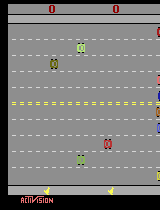

In [45]:
transform = lambda x: x  # noqa: E731
random_agent = RandomAgent(env)
simulate(env, transform, random_agent, 1, 100)

# Reinforcement Learning Agent


Now that we have a way for an agent to interact with our environment, we can go ahead and develop a RL agent capable of playing the game Crossy Road.

This is a fairly complicated game, so [ordinary Q-learning](https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial) won't necesarily work.

Instead, we will use a variation called [deep Q-learning](https://huggingface.co/learn/deep-rl-course/en/unit3/deep-q-algorithm) that utilizes deep Q-networks (DQNs).

It works similarly to ordinary Q-learning, except it approximates the Q-values for each possible action at a state using a deep neural network instead of calculating the exact values.

We will follow PyTorch's official [Reinforcement Learning (DQN) Tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) as a guide, and adapt it to suit our needs.


## Defining Hyperparameters


Let's start off by defining the hyperparameters we will use.


In [46]:
hparams = {
    "memory_capacity": 10000,
    "num_episodes": 5,
    "learning_rate": 1e-4,  # alpha
    "exploration_rate": {  # epsilon
        "start": 0.9,
        "end": 0.05,
        "decay": 1000,
    },
    "update_rate": 0.005,  # tau
}

## Preprocessing Data


Before we can perform deep Q-learning, we'll need to preprocess our data to make it suitable for training.

We can specify a [transformation function](https://pytorch.org/vision/stable/transforms.html) to transform or augment our data to fit our needs.

Here, we will:

- Turn the RGB values into an image
- Make the image grayscale
- Change the datatype to `float32`
- Flatten the image into a single dimension


In [47]:
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Grayscale(),
        v2.ToDtype(dtype=torch.float32, scale=True),
        v2.Lambda(lambda x: torch.flatten(input=x).to(device)),
    ]
)

## Defining Models


Next, we can define our models, i.e. build our neural networks for use in the deep Q-learning algorithm. We will be using a deep Q-network (DQN).

Our model will be a [feed-forward neural network](https://www.analyticsvidhya.com/blog/2022/03/basic-introduction-to-feed-forward-network-in-deep-learning/) that takes in the difference between the current and previous screen patches in order to predict the Q-values.

Essentially, the network is used to predict the expected return of taking each action given the current state.


In [48]:
class DQN(nn.Module):
    def __init__(self, observation_size, action_size):
        super().__init__()
        self.layer1 = nn.Linear(observation_size, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Defining Loss Function and Optimizer


With our network defined, we can now define our loss function and optimizer.


### Loss Function


We will use [smooth L1 loss](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html), as is common for DQN.


In [49]:
loss_fn = nn.SmoothL1Loss()

### Optimizer


We will use the [AdamW (adaptive momentum estimation with weight decay)](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) optimizer, since it is particulalry robust.

It combines the benefits of momentum (such as in [SGD (stochastic gradient descent)](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) with momentum) and adaptive learning rates (such as in [RMSprop (root mean square propagation)](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)).


In [50]:
optimizer = optim.AdamW

## Defining Experience Replay Memory


To perform deep Q-learning, we'll rely on a technique known as [experience replay memory](https://paperswithcode.com/method/experience-replay).


### Representing a Transition


First, we'll represent a transition using a tuple of the form `(observation, action, next_observation, reward)`, which maps a `(observation, action)` pair to the corresponding result `(next_observation, reward)`.


In [51]:
Transition = namedtuple(
    "Transition", ("observation", "action", "next_observation", "reward")
)

### Representing Replay Memory


Next, we'll represent replay memory using a deque (double-ended queue) of fixed capacity. It will store the transitions observed most recently.

We'll also have a method for selecting a random batch of transitions.


In [52]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Deep Q-Network Agent


Now, we are ready to build our DQN agent.


### Initializing the Agent


In the `__init__()` method, we do the following:

- Define the hyperparameters using the given values:

  - `hparams`: the dictionary of hyperparameters

- Preprocess the data to form a suitable training environment `env`:

  - Wrap the given enivronment `env` in a `TransformObservation` wrapper that transforms the observation using the given transformation function `transform`.
  - Calculate the relevant sizes of the environment:
    - `observation_size`: the size of an observation in the observation space
    - `action_size`: the size of an action in the action space

- Define the models (neural networks):

  - `policy_net`: used for action selection (to select the best action to take at a given state, i.e. the action with the highest Q-value)
  - `target_net`: used for action evaluation (to calculate the target Q-value of taking that action at the given state)
    - Note that `target_net` is just a copy of `policy_net` that's updated less frequently.

- Define the loss function and optimizer using the given values:

  - `loss_fn`: the loss function
  - `optimizer`: the optimizer

- Define the experience replay memory:
  - `memory`: the memory
- Define variables used for training:
  - `total_steps`: the total number of steps (the number of times an action was sampled)
  - `episode_durations`: how long each episode takes


In [53]:
class DQNAgent:
    def __init__(self, hparams, env, transform, loss_fn, optimizer):
        # defining hyperparameters
        self.hparams = copy.deepcopy(hparams)

        # preprocessing data
        self.env = TransformObservation(env, transform)
        observation, _ = self.env.reset()
        self.observation_size = len(observation)
        self.action_size = self.env.action_space.n

        # defining models
        self.policy_net = DQN(self.observation_size, self.action_size).to(device)
        self.target_net = DQN(self.observation_size, self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        # defining loss function and optimizer
        self.loss_fn = loss_fn
        self.optimizer = optimizer(
            params=self.policy_net.parameters(),
            lr=self.hparams["learning_rate"],
            amsgrad=True,
        )

        # defining experience replay memory
        self.memory = ReplayMemory(self.hparams["memory_capacity"])

        # defining variables for training
        self.total_steps = 0
        self.episode_durations = []

### Sampling an Action from the Policy


In the `sample_action()` method, the agent will sample an action using an epsilon-greedy policy, which means balancing the amount of exploration vs. exploitation as per the hyperparameter for exploration rate (epsilon, $\epsilon$).

Note that we are using epsilon decay, so the exploration rate will decrease exponentially over time.


In [54]:
class DQNAgent(DQNAgent):
    def sample_action(self, observation):
        # epsilon
        exploration_rate = self.hparams["exploration_rate"]["end"] + (
            self.hparams["exploration_rate"]["start"]
            - self.hparams["exploration_rate"]["end"]
        ) * math.exp(
            -1.0 * self.total_steps / self.hparams["exploration_rate"]["decay"]
        )
        self.total_steps += 1

        if np.random.uniform(0, 1) < exploration_rate:  # explore
            action = self.env.action_space.sample()
        else:  # exploit
            return self.policy_net(observation).argmax(dim=0)

        # convert action to tensor
        return torch.tensor(
            data=action,
            dtype=torch.int32,
            device=device,
        )

### Plotting Episode Durations


To visualize our training progress, we will create a `plot_episode_durations()` method that plots the durations of episodes, along with a rolling average over the last $100$ episodes.


In [55]:
class DQNAgent(DQNAgent):
    def plot_episode_durations(self):
        # convert episode durations to tensor
        episode_durations_tensor = torch.tensor(
            self.episode_durations, dtype=torch.float32
        )

        # set up figure
        plt.figure()
        plt.title("Episode Durations")
        plt.xlabel("Episode")
        plt.ylabel("Duration")

        # make x-axis use integers
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=0))

        # plot episode durations
        plt.plot(episode_durations_tensor.numpy())

        # plot rolling average of episode durations
        if len(episode_durations_tensor) >= 100:
            means = (
                episode_durations_tensor.unfold(dimension=0, size=100, step=1)
                .mean(dim=1)
                .view(size=-1)
            )
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

### Optimizing the Policy Network


TODO


In [56]:
class DQNAgent(DQNAgent):
    def optimize_policy_net(self):
        pass

### Optimizing the Target Network


In the `optimize_target_net()` method, we update the target network's weights. It's a soft update based on the hyperparameter for update rate (tau, $\tau$).


In [57]:
class DQNAgent(DQNAgent):
    def optimize_target_net(self):
        # get state dictionaries
        policy_net_state_dict = self.policy_net.state_dict()
        target_net_state_dict = self.target_net.state_dict()

        # update target net state dictionary
        for key in policy_net_state_dict:
            old_weight = (1 - self.hparams["update_rate"]) * target_net_state_dict[key]
            new_weight = self.hparams["update_rate"] * policy_net_state_dict[key]
            target_net_state_dict[key] = old_weight + new_weight

        # load target net state dictionary into target net
        self.target_net.load_state_dict(target_net_state_dict)

### Training the Agent


In the `train()` method, we train our agent in order to make its policy "better" at solving the environment.

We also handle saving and loading of the models and plots as necessary.


In [58]:
class DQNAgent(DQNAgent):
    def train(self):
        # load models and plots if available
        if (
            Path("policy_net.pth").is_file()
            and Path("target_net.pth").is_file()
            and Path("episode_durations.png").is_file()
        ):
            self.policy_net.load_state_dict(torch.load("policy_net.pth"))
            self.target_net.load_state_dict(torch.load("target_net.pth"))
            img = plt.imread("episode_durations.png")
            plt.axis("off")
            plt.imshow(img)
            return

        for _ in trange(self.hparams["num_episodes"], desc="Episodes"):
            # reset environment
            display.clear_output(wait=True)
            step = 0
            observation, _ = self.env.reset()
            observation = observation.clone().detach()
            reward, terminated, truncated = 0.0, False, False

            while not (terminated or truncated):
                step += 1

                # sample action from policy
                action = self.sample_action(observation)
                action = action.clone().detach()
                next_observation, reward, terminated, truncated, _ = self.env.step(
                    action.item()
                )
                next_observation = (
                    None if terminated else next_observation.clone().detach()
                )
                reward = torch.tensor(data=reward, dtype=torch.float32, device=device)
                reward = reward.clone().detach()

                # store transition in memory
                self.memory.push(observation, action, next_observation, reward)

                # move to next observation
                observation = next_observation

                # optimize model
                self.optimize_policy_net()
                self.optimize_target_net()

            # log episode duration and update plot
            self.episode_durations.append(step)
            self.plot_episode_durations()
            plt.show()

        # update plot
        display.clear_output(wait=True)
        self.plot_episode_durations()

        # get current timestamp
        timestamp = datetime.now().isoformat(timespec="minutes")

        # same models and plots in current directory
        torch.save(self.policy_net.state_dict(), "policy_net.pth")
        torch.save(self.target_net.state_dict(), "target_net.pth")
        plt.savefig("episode_durations.png")

        # save archive of models and plots in runs/ directory
        Path(f"runs/{timestamp}").mkdir(parents=True, exist_ok=True)
        torch.save(self.policy_net.state_dict(), f"runs/{timestamp}/policy_net.pth")
        torch.save(self.target_net.state_dict(), f"runs/{timestamp}/target_net.pth")
        plt.savefig(f"runs/{timestamp}/episode_durations.png")

        # show plot
        plt.show()

### Inference Mode


In the `inference_mode()` method, we set the hyperparameters for exploration rate (epsilon, $\epsilon$) to $0$, so we don't explore anymore and only exploit.


In [59]:
class DQNAgent(DQNAgent):
    def inference_mode(self):
        self.hparams["exploration_rate"]["start"] = 0.0
        self.hparams["exploration_rate"]["end"] = 0.0

## Training the Agent


Now, we're equipped with everything we need to train our DQN agent.


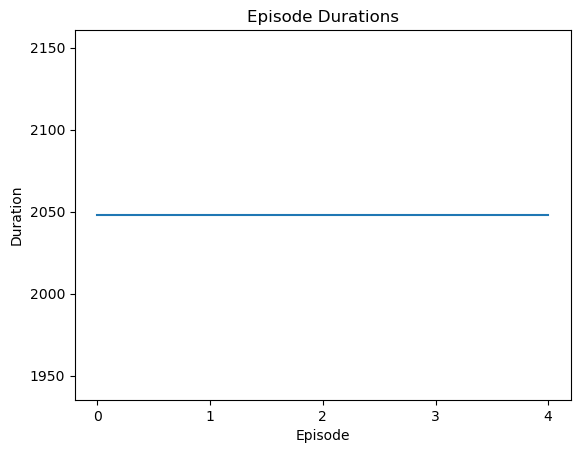

In [60]:
dqn_agent = DQNAgent(hparams, env, transform, loss_fn, optimizer)
dqn_agent.train()

## Simulation


Now, let's run a simulation.

To limit the amount of output we need to scroll through, we will only show every $100$ steps.


########## Episode 0 ##########

***** Step 0 *****

Reward: 0.0
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 0, 'frame_number': 49151}


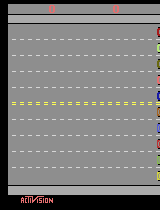


***** Step 100 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 400, 'frame_number': 49551}


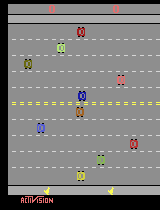


***** Step 200 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 800, 'frame_number': 49951}


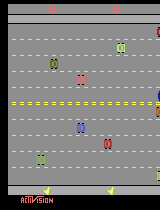


***** Step 300 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 1200, 'frame_number': 50351}


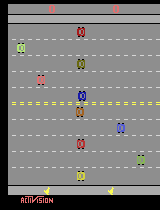


***** Step 400 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 1600, 'frame_number': 50751}


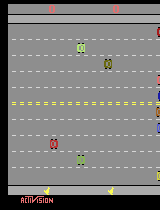


***** Step 500 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 2000, 'frame_number': 51151}


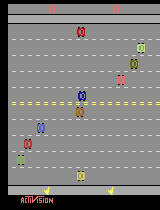


***** Step 600 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 2400, 'frame_number': 51551}


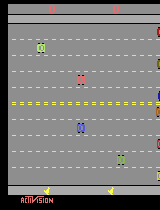


***** Step 700 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 2800, 'frame_number': 51951}


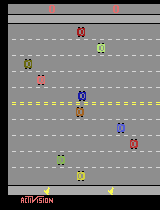


***** Step 800 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 3200, 'frame_number': 52351}


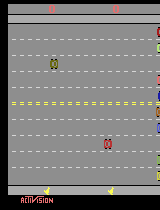


***** Step 900 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 3600, 'frame_number': 52751}


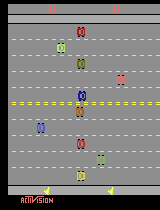


***** Step 1000 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 4000, 'frame_number': 53151}


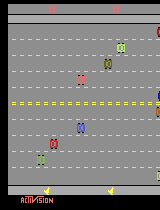


***** Step 1100 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 4400, 'frame_number': 53551}


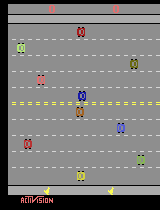


***** Step 1200 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 4800, 'frame_number': 53951}


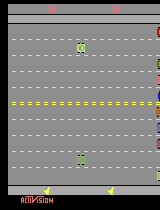


***** Step 1300 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 5200, 'frame_number': 54351}


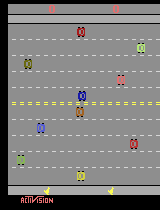


***** Step 1400 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 5600, 'frame_number': 54751}


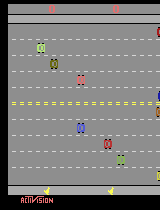


***** Step 1500 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 6000, 'frame_number': 55151}


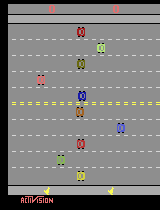


***** Step 1600 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 6400, 'frame_number': 55551}


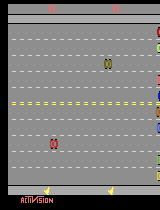


***** Step 1700 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 6800, 'frame_number': 55951}


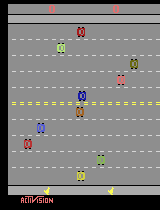


***** Step 1800 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 7200, 'frame_number': 56351}


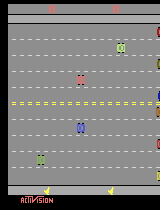


***** Step 1900 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 7600, 'frame_number': 56751}


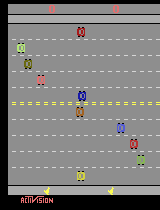


***** Step 2000 *****

Action: 0 (NOOP)
Reward: -0.05
Terminated: False
Truncated: False
Info: {'lives': 0, 'episode_frame_number': 8000, 'frame_number': 57151}


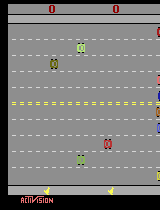

In [61]:
dqn_agent.inference_mode()
simulate(env, transform, dqn_agent, 1, 100)

# TODO: Reorganize


In [62]:
# TODO: implement DQN agent (follow training section in tutorial)
# NOTE: put everything in one class instead of just separate functions
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
episode_durations = []
is_ipython = "inline" in matplotlib.get_backend()


class DQNAgent:
    def __init__(
        self,
        n_actions,
        state,
        info,
        n_observations,
        policy_net,
        target_net,
        optimizer,
        memory,
        episode_durations,
        is_ipython,
    ):
        self.n_actions = n_actions
        self.state = state
        self.info = info
        self.n_observations = n_observations
        self.policy_net = policy_net
        self.target_net = target_net
        self.optimizer = optimizer
        self.memory = memory
        self.episode_durations = episode_durations
        self.is_ipython = is_ipython
        self.steps_done = 0

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(
            -1.0 * self.steps_done / EPS_DECAY
        )
        self.steps_done += 1
        if sample > eps_threshold:
            with torch.no_grad():
                # Pass the state through the policy network (self.policy_net)
                print(state.shape)
                q_values = self.policy_net(state)
                return q_values.max(1).indices.view(1, 1)
        else:
            return torch.tensor(
                [[env.action_space.sample()]], device=device, dtype=torch.long
            )

    def plot_durations(show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(episode_durations, dtype=torch.float)
        if show_result:
            plt.title("Result")
        else:
            plt.clf()
            plt.title("Training...")
        plt.xlabel("Episode")
        plt.ylabel("Duration")
        plt.plot(durations_t.numpy())
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)  # pause a bit so that plots are updated
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())

    def optimize_model(self):
        if len(memory) < BATCH_SIZE:
            return
        transitions = memory.sample(BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions, strict=True))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)),
            device=device,
            dtype=torch.bool,
        )
        non_final_next_states = torch.cat(
            [s for s in batch.next_state if s is not None]
        )
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1).values
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = (
                target_net(non_final_next_states).max(1).values
            )
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
        optimizer.step()

    def train(self):
        if torch.cuda.is_available():
            num_episodes = 600
        else:
            num_episodes = 50

        for _ in range(num_episodes):
            # Initialize the environment and get its state
            state, info = env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            for t in count():
                action = self.select_action(state)
                observation, reward, terminated, truncated, _ = env.step(action.item())
                reward = torch.tensor([reward], device=device)
                done = terminated or truncated

                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(
                        observation, dtype=torch.float32, device=device
                    ).unsqueeze(0)

                # Store the transition in memory
                memory.push(state, action, next_state, reward)

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                self.optimize_model()

                # Soft update of the target network's weights
                # θ′ ← τ θ + (1 −τ )θ′
                target_net_state_dict = target_net.state_dict()
                policy_net_state_dict = policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] = policy_net_state_dict[
                        key
                    ] * TAU + target_net_state_dict[key] * (1 - TAU)
                target_net.load_state_dict(target_net_state_dict)

                if done:
                    episode_durations.append(t + 1)
                    self.plot_durations()
                    break

        print("Complete")
        self.plot_durations(show_result=True)
        plt.ioff()
        plt.show()


model = DQNAgent(
    n_actions,
    state,
    info,
    n_observations,
    policy_net,
    target_net,
    optimizer,
    memory,
    episode_durations,
    is_ipython,
)
model.train()

torch.Size([1, 210, 160, 3])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (33600x3 and 210x128)

# Conclusion
